In [47]:
import tensorflow as tf
from keras.metrics import AUC
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.metrics import Precision, Recall
from keras.losses import BinaryCrossentropy
import datetime
from model.nn import multichannel_network
from model.data import Dataset, DataGenerator
from sklearn.utils import class_weight
import numpy as np

tf.random.set_seed(42)
# Dataset Setting: 
## choose from ['methylation', 'gene_expression', 'cnv', 'mutation']
FEATURE = ['cnv', ] 
ds = Dataset(
    feature_contained=FEATURE, 
    dataset='CTRP', 
    set_label=True, 
    response='AUC', 
    threshold=.58)
# CTRP, "AUC", 0.58, 0.001
# GDSC, "AUC", .88, 0.001
# model parameters settings
ds.save()
lr_rate = 0.01
dropout_rate = .5
batch_size = 64
epochs = 3

# Split train, test and validation set for training and testing, build generators
partition = ds.split(validation=True)
train = partition['train']
test = partition['test']
validation = partition['validation']
train_generator = DataGenerator(sample_barcode=train, **ds.get_config(), batch_size=batch_size)
validation_generator = DataGenerator(sample_barcode=validation, **ds.get_config(), batch_size=batch_size)
test_generator = DataGenerator(sample_barcode=test, **ds.get_config(), batch_size=batch_size)

# Training parameters
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique([ds.labels[x] for x in train]),
                                                 y=[ds.labels[x] for x in train])
weights_dict = {i:w for i,w in enumerate(class_weights)}
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
    if(epoch % 1 ==0 and epoch !=0):
        return lr*0.1
    else:
        return lr
reduce_lr = LearningRateScheduler(scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)


# model building
model = multichannel_network(
    data=ds.omics_data,
    feature_contained = ds.feature_contained,
    train_sample_barcode=train,
    dropout=dropout_rate
    )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
              loss=BinaryCrossentropy(),
              metrics=
              [
                Precision(name="precision"),
                Recall(name="recall"),
                AUC(curve='ROC'),
                AUC(curve='PR')
              ]
            )

history = model.fit(
    x=train_generator, 
    epochs=epochs,
    validation_data=validation_generator, 
    callbacks=[reduce_lr, early_stop],
    class_weight=weights_dict
                    )

scores = model.evaluate(x=test_generator) 
print(list(scores))


Loading Copy Number Abberation Data...
Loading Copy Number Abberation Data Done
Begin loading drug data...
After filtering, GDSC has tested 477 drugs; CTRP has tested 545 drugs
After combining, unique Drug number is 909


  0%|          | 0/909 [00:00<?, ?it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_cdf
  np.place(out, cond, f(*temp))
/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6630: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
  0%|          | 2/909 [00:00<01:05, 13.85it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
100%|██████████| 909/909 [00:43<00:00, 20.73it/s]


Drug data loaded
Loading CTRP Experiment Data...
Loading Experiment Data Done
Begin Preprocessing Experiment!
Select Overlapping Cellines...
Index(['DRUG_NAME', 'SMILES', 'CELL_LINE_NAME', 'AUC', 'DATASET'], dtype='object')
Select Overlapping Cellines with available PubChem CIDs...
Create Unique Sample Barcode...
Exclude response value...
Experiment Done!
Preparing Omics data...
Omics data Done!
Data Loaded. We have 51413 sample barcodes in whole dataset!
Save the dataset into hdf5 data format...
Done!
Epoch 1/3
642/642 [==============================] - 53s 79ms/step - loss: 0.4852 - precision: 0.6266 - recall: 0.7720 - auc_2: 0.8496 - auc_3: 0.7438 - val_loss: 0.3883 - val_precision: 0.7327 - val_recall: 0.7488 - val_auc_2: 0.8933 - val_auc_3: 0.8266 - lr: 0.0100
Epoch 2/3
642/642 [==============================] - 52s 80ms/step - loss: 0.3785 - precision: 0.7099 - recall: 0.8380 - auc_2: 0.9113 - auc_3: 0.8450 - val_loss: 0.3862 - val_precision: 0.6786 - val_recall: 0.8865 - val_auc

In [48]:
tf.saved_model.save(model, 'CTRP_0.01_1-0.1_64_3_cnv')

INFO:tensorflow:Assets written to: CTRP_0.01_1-0.1_64_3_cnv/assets


INFO:tensorflow:Assets written to: CTRP_0.01_1-0.1_64_3_cnv/assets


In [49]:
_model_ = tf.saved_model.load('CTRP_0.01_1-0.1_64_3_cnv')

In [54]:
from tqdm import tqdm
import pandas as pd
def make_predict(model, candidate, ds, batch_size):
    """

    Args:
        candidate (list): list["CELLINE_DRUG"]
        ds (Dataset): Dataset Object
    """
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    for i in ds.feature_contained:
        if i == "cnv":
            feature['cnv'] = ds.omics_data['cnv'].loc[celline_candidate].values.astype(np.float32)
        elif i == "gene_expression":
            feature['gene_expression'] = ds.omics_data['gene_expression'].loc[celline_candidate].values.astype(np.float32)
        elif i == "mutation":
            feature['mutation'] = ds.omics_data['mutation'].loc[celline_candidate].values.astype(np.float32)
        elif i == "methylation":
            feature['methylation'] = ds.omics_data['methylation'].loc[celline_candidate].values.astype(np.float32)
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)
    chunks = []

    for i in range(0, len(candidate), batch_size):
        x = i
        chunks.append({i:feature[i][x:x+batch_size] for i in ds.feature_contained}.update(
            {
                "fingerprint": feature["fingerprint"][x:x+batch_size],
                "rdkit2d": feature['rdkit2d'][x:x+batch_size]
            }
        ))
    result = []

    for i in tqdm(chunks):
        result.append(model(i))
    print(result)
    result = np.concatenate(result, axis=-2)
    # result = result[0:len(candidate)]
    import pandas as pd
    df = pd.DataFrame(data=result, columns=['Sensitivity'])
    df['DRUG_NAME'] = drug_candidate
    df['CELL_LINE'] = celline_candidate
    return df 

# ANALYSIS

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## GDSC and CTRPv2 Basic Statistics

CTRP AUC Histogram

<AxesSubplot:xlabel='AUC', ylabel='Count'>

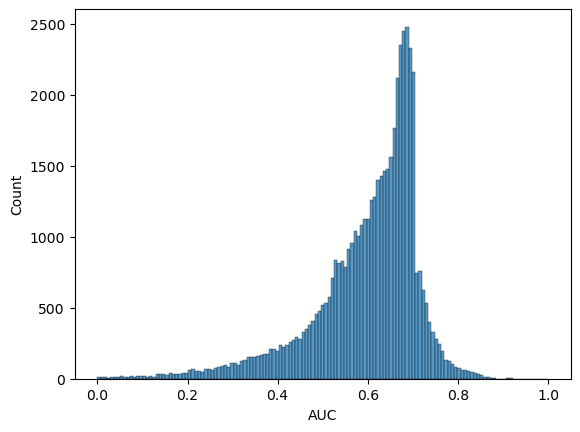

In [52]:
sns.histplot(data=ds.response['AUC'])

## AUC, AUPRC and Confusion Matrix over test dataset

In [55]:
pred_df = make_predict(model=_model_, candidate=test, ds=ds, batch_size=64)

  0%|          | 0/81 [00:00<?, ?it/s]


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * {'cnv': <tf.Tensor 'inputs:0' shape=(64, 20669) dtype=float32>}
  Keyword arguments: {'training': False}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (1 total):
    * {'cnv': TensorSpec(shape=(None, 20669), dtype=tf.float32, name='cnv'),
 'fingerprint': TensorSpec(shape=(None, 1024), dtype=tf.float32, name='fingerprint'),
 'rdkit2d': TensorSpec(shape=(None, 200), dtype=tf.float32, name='rdkit2d')}
  Keyword arguments: {'training': False}

Option 2:
  Positional arguments (1 total):
    * {'cnv': TensorSpec(shape=(None, 20669), dtype=tf.float32, name='inputs_cnv'),
 'fingerprint': TensorSpec(shape=(None, 1024), dtype=tf.float32, name='inputs_fingerprint'),
 'rdkit2d': TensorSpec(shape=(None, 200), dtype=tf.float32, name='inputs_rdkit2d')}
  Keyword arguments: {'training': False}

Option 3:
  Positional arguments (1 total):
    * {'cnv': TensorSpec(shape=(None, 20669), dtype=tf.float32, name='inputs_cnv'),
 'fingerprint': TensorSpec(shape=(None, 1024), dtype=tf.float32, name='inputs_fingerprint'),
 'rdkit2d': TensorSpec(shape=(None, 200), dtype=tf.float32, name='inputs_rdkit2d')}
  Keyword arguments: {'training': True}

Option 4:
  Positional arguments (1 total):
    * {'cnv': TensorSpec(shape=(None, 20669), dtype=tf.float32, name='cnv'),
 'fingerprint': TensorSpec(shape=(None, 1024), dtype=tf.float32, name='fingerprint'),
 'rdkit2d': TensorSpec(shape=(None, 200), dtype=tf.float32, name='rdkit2d')}
  Keyword arguments: {'training': True}

In [9]:
pred_df['true_labels'] = [ds.labels[i] for i in test]

In [10]:
pred_df.rename(columns={"AUC_predicted": "Sensitivity"}, inplace=True)

In [11]:
pred_df['pred_labels'] = [1 if i>0.5 else 0 for i in pred_df['Sensitivity']]

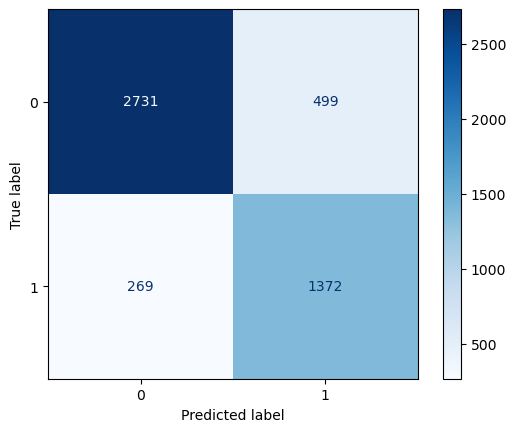

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['pred_labels']))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


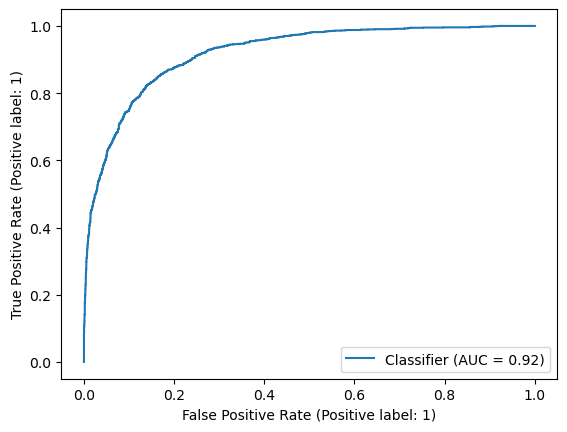

In [13]:
RocCurveDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

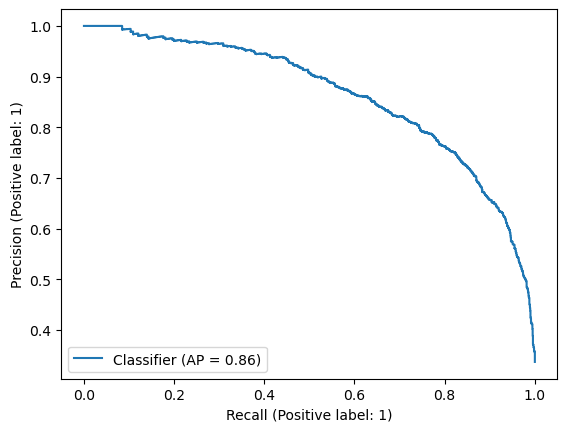

In [14]:
PrecisionRecallDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

## Predicted Scores Comparison between sensitive and insensitive drugs

<AxesSubplot:xlabel='true_labels', ylabel='Sensitivity'>

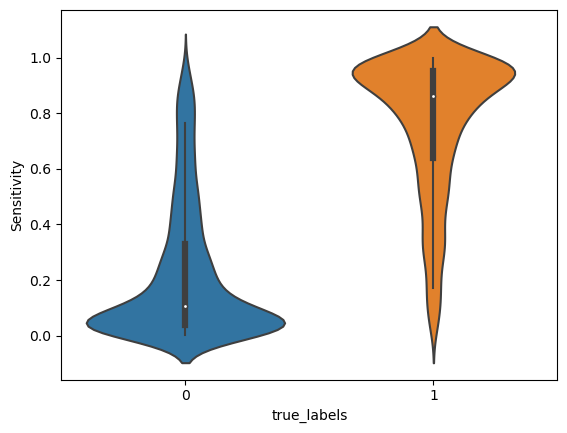

In [15]:
sns.violinplot(data=pred_df, x="true_labels", y="Sensitivity")

## Test Cancer(Lung, Colon, Breast, Stomach) Across drug types 

Find all cellines related to Colon Cancer

In [16]:
model_list = pd.read_csv('data/raw_data/model_list_20230307.csv')
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
breast_ccl = model_list[(model_list['tissue'] == 'Breast') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
colo_ccl = model_list[((model_list['tissue'] == 'Small Intestine') | (model_list['tissue'] == 'Large Intestine')) & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
stomach_ccl = model_list[(model_list['tissue'] == 'Stomach') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']


In [17]:
celline_barcode = set(ds.celline_barcode)
colo_ccl = set(colo_ccl).intersection(celline_barcode)
lung_ccl = set(lung_ccl).intersection(celline_barcode)
breast_ccl = set(breast_ccl).intersection(celline_barcode)
stomach_ccl = set(stomach_ccl).intersection(celline_barcode)
drug_candidate = set(ds.drug_info.all_drugs.index).difference(set(ds.processed_experiment['DRUG_NAME']))

In [18]:
import itertools
l = {"colo": colo_ccl, "lung": lung_ccl, "breast": breast_ccl, "stomach": stomach_ccl}
experiment_candidate_dict = {name:itertools.product(i, drug_candidate) for name, i in l.items()}
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = ["_".join(i) for i in itm]

In [20]:
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = make_predict(model=_model_, candidate=itm, ds=ds, batch_size=64)

100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.08444084],
       [0.26052052],
       [0.25047746],
       [0.18619365],
       [0.27719042],
       [0.3924778 ],
       [0.2977611 ],
       [0.4131657 ],
       [0.5089496 ],
       [0.14773457],
       [0.700278  ],
       [0.8158262 ],
       [0.02616934],
       [0.6306151 ],
       [0.8024164 ],
       [0.3702729 ],
       [0.08841561],
       [0.6294077 ],
       [0.07848004],
       [0.275213  ],
       [0.10582495],
       [0.8425335 ],
       [0.5017104 ],
       [0.7620343 ],
       [0.6932046 ],
       [0.2334704 ],
       [0.06554783],
       [0.18693078],
       [0.82936645],
       [0.15347736],
       [0.6843518 ],
       [0.41142505],
       [0.03668554],
       [0.39820254],
       [0.12898193],
       [0.12079947],
       [0.83804464],
       [0.02730315],
       [0.0493248 ],
       [0.04227134],
       [0.23582238],
       [0.52913064],
       [0.9374168 ],
       [0.02684048],
       [0.7805166 ],
     

100%|██████████| 29/29 [00:06<00:00,  4.34it/s]


[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.05524437],
       [0.13935895],
       [0.13179018],
       [0.11707688],
       [0.16476144],
       [0.28148553],
       [0.1883392 ],
       [0.28107414],
       [0.26006195],
       [0.08583042],
       [0.52800596],
       [0.66381896],
       [0.01571658],
       [0.44531238],
       [0.6999568 ],
       [0.19017342],
       [0.0510518 ],
       [0.50482327],
       [0.04436569],
       [0.1630338 ],
       [0.07262203],
       [0.7518944 ],
       [0.33897728],
       [0.646405  ],
       [0.4968075 ],
       [0.14777435],
       [0.04189144],
       [0.10356034],
       [0.7214987 ],
       [0.10161504],
       [0.5497092 ],
       [0.29694182],
       [0.02170649],
       [0.25088492],
       [0.08328886],
       [0.06885543],
       [0.7213829 ],
       [0.01522939],
       [0.03182272],
       [0.03160883],
       [0.16244997],
       [0.42966458],
       [0.88322574],
       [0.01908506],
       [0.6895368 ],
     

100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.13947491],
       [0.42324302],
       [0.48837468],
       [0.3861596 ],
       [0.41993117],
       [0.60384125],
       [0.4746474 ],
       [0.61969393],
       [0.7140364 ],
       [0.25381762],
       [0.8655619 ],
       [0.91868234],
       [0.04892705],
       [0.7966139 ],
       [0.91133136],
       [0.64085907],
       [0.16514744],
       [0.7695218 ],
       [0.13510534],
       [0.43556443],
       [0.22424707],
       [0.9252614 ],
       [0.710678  ],
       [0.8732166 ],
       [0.8612244 ],
       [0.43179944],
       [0.14492458],
       [0.29674944],
       [0.92930144],
       [0.31143057],
       [0.83025163],
       [0.5733564 ],
       [0.06627014],
       [0.61716056],
       [0.20724364],
       [0.26128024],
       [0.93542016],
       [0.04849235],
       [0.09260356],
       [0.09503963],
       [0.41258392],
       [0.7506027 ],
       [0.9774926 ],
       [0.04755067],
       [0.9027747 ],
     

100%|██████████| 23/23 [00:05<00:00,  4.30it/s]

[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.1706161 ],
       [0.38204506],
       [0.44779837],
       [0.38270977],
       [0.37988654],
       [0.55185235],
       [0.42208835],
       [0.5552038 ],
       [0.6594787 ],
       [0.2678549 ],
       [0.8186067 ],
       [0.88770455],
       [0.05295091],
       [0.746036  ],
       [0.8814334 ],
       [0.581043  ],
       [0.16951852],
       [0.733912  ],
       [0.14277053],
       [0.38889158],
       [0.25499883],
       [0.90057313],
       [0.6518203 ],
       [0.8374346 ],
       [0.8155728 ],
       [0.38614255],
       [0.16350399],
       [0.2842219 ],
       [0.90528613],
       [0.3386901 ],
       [0.78350395],
       [0.5259029 ],
       [0.07473251],
       [0.55647147],
       [0.21903013],
       [0.23821503],
       [0.9124157 ],
       [0.05554788],
       [0.10691134],
       [0.11143243],
       [0.4400537 ],
       [0.6833161 ],
       [0.9677148 ],
       [0.06346054],
       [0.87595147],
     

In [21]:
experiment_candidate_dict['breast']

,Sensitivity,DRUG_NAME,CELL_LINE
0,0.139475,Talazoparib,HCC1954
1,0.423243,Erlotinib,HCC1954
2,0.488375,Bromosporine,HCC1954
3,0.386160,T0901317,HCC1954
4,0.419931,Tivozanib,HCC1954
...,...,...,...
3999,0.370024,Podophyllotoxin bromide,HCC1143
4000,0.654789,WH-4-023,HCC1143
4001,0.497730,Torin 2,HCC1143
4002,0.777970,LDN-193189,HCC1143


In [22]:
breast_drug_df = experiment_candidate_dict['breast'].groupby('DRUG_NAME').mean()
colo_drug_df = experiment_candidate_dict['colo'].groupby('DRUG_NAME').mean()
lung_drug_df = experiment_candidate_dict['lung'].groupby('DRUG_NAME').mean()
stomach_drug_df = experiment_candidate_dict['stomach'].groupby('DRUG_NAME').mean()

In [23]:
colo_set = set(colo_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
stomach_set = set(stomach_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
lung_set = set(lung_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
breast_set = set(breast_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)

In [24]:
common_set = colo_set.intersection(stomach_set, lung_set, breast_set)

In [25]:
print(f"Colon: {colo_set.difference(common_set)}")
print(f"Stomach: {stomach_set.difference(common_set)}")
print(f"Lung: {lung_set.difference(common_set)}")
print(f"Breast: {breast_set.difference(common_set)}")

Colon: {'GW441756'}
Stomach: {'Pictilisib'}
Lung: {'Pictilisib'}
Breast: {'Pictilisib'}


## Test type-specific drugs Across Cancer Types

Gefitinib Lung Cancer-specific

In [27]:
gefitinib_entry = ["_".join((i, "gefitinib")) for i in ds.celline_barcode]

In [28]:
gefitinib_df = make_predict(model=model, candidate = gefitinib_entry, ds=ds, batch_size=64)

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.7784244 ],
       [0.57219654],
       [0.90398306],
       [0.57700026],
       [0.33038926],
       [0.08899202],
       [0.2868913 ],
       [0.48995498],
       [0.2982499 ],
       [0.34855363],
       [0.792695  ],
       [0.15220185],
       [0.3847715 ],
       [0.39865562],
       [0.60070515],
       [0.44297752],
       [0.42220226],
       [0.21035905],
       [0.2895899 ],
       [0.3033277 ],
       [0.34212336],
       [0.90657926],
       [0.2610775 ],
       [0.20855643],
       [0.7843831 ],
       [0.3883036 ],
       [0.56227046],
       [0.79743445],
       [0.338171  ],
       [0.39873272],
       [0.5442124 ],
       [0.3489693 ],
       [0.4431104 ],
       [0.42407107],
       [0.23526506],
       [0.66577166],
       [0.7256902 ],
       [0.6578733 ],
       [0.69353247],
       [0.8628913 ],
       [0.44142878],
       [0.623233  ],
       [0.70985544],
       [0.3653766 ],
       [0.3823165 ],
     

In [29]:
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']

In [30]:
gefitinib_df[gefitinib_df['CELL_LINE'].isin(lung_ccl)]

,Sensitivity,DRUG_NAME,CELL_LINE
32,0.443110,gefitinib,SW1271
45,0.473407,gefitinib,EKVX
68,0.485652,gefitinib,HARA
80,0.315671,gefitinib,A549
85,0.734703,gefitinib,SW1573


## PRISM Holdout Validation

In [31]:
import pandas as pd
import numpy as np
from model.data import Dataset

In [32]:
prism = pd.read_csv('data/PRISM/secondary-screen-dose-response-curve-parameters.csv', low_memory=False)

In [33]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
prism['auc'] = minmax_scale(X=prism['auc'])
prism['auc'].quantile([0.3333, 0.66666, 0.9]) # threshold = 0.1728

0.33330    0.172789
0.66666    0.203854
0.90000    0.272822
Name: auc, dtype: float64

In [34]:
prism_drug = pd.DataFrame()
prism_drug['DRUG_NAME'] = prism['name']
prism_drug['CanonicalSMILES'] = prism['smiles']
prism_drug.drop_duplicates(subset='DRUG_NAME', keep='first', inplace=True)
prism_drug.reset_index(inplace=True, drop=True)
prism_drug_overlapped = list(set(prism_drug['DRUG_NAME']).intersection(set(ds.drug_info.all_drugs.index)))

In [35]:
prism['ccle_name'] = [str(i).split("_")[0] for i in prism['ccle_name']]

In [36]:
prism_experiment = prism[(prism['ccle_name'].isin(ds.celline_barcode))&(prism['name'].isin(prism_drug_overlapped))].reset_index(drop=True)

In [37]:
experiment_id = ["_".join((str(i), j)) for i,j in zip(prism_experiment['ccle_name'], prism_experiment['name'])]

In [38]:
experiment_df = pd.DataFrame()
experiment_df['SAMPLE_BARCODE'] = experiment_id
experiment_df['AUC'] = prism_experiment['auc']
experiment_df['LABELS'] = [1 if i<0.1728 else 0 for i in prism_experiment['auc'] ]


In [39]:
experiment_candidate_prism = list(set(experiment_df['SAMPLE_BARCODE']).difference(train))

In [40]:
len(experiment_candidate_prism)

4760

In [42]:
pred_df = make_predict(model=_model_, candidate=experiment_candidate_prism, ds=ds, batch_size=64)

100%|██████████| 75/75 [00:20<00:00,  3.65it/s]

[<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.27990198],
       [0.3705607 ],
       [0.07553616],
       [0.32931975],
       [0.93851227],
       [0.7961298 ],
       [0.05181217],
       [0.85317224],
       [0.98590314],
       [0.93568385],
       [0.81218815],
       [0.38813004],
       [0.94566596],
       [0.16917215],
       [0.41620836],
       [0.3292227 ],
       [0.7500179 ],
       [0.6150342 ],
       [0.07947187],
       [0.60130066],
       [0.4480603 ],
       [0.21029173],
       [0.23717257],
       [0.75214815],
       [0.6335595 ],
       [0.2878658 ],
       [0.03870063],
       [0.03126466],
       [0.08257589],
       [0.2507955 ],
       [0.3330945 ],
       [0.43918952],
       [0.936462  ],
       [0.86325526],
       [0.52514374],
       [0.78571355],
       [0.8675042 ],
       [0.25253823],
       [0.06356715],
       [0.01726278],
       [0.98733   ],
       [0.99236065],
       [0.92634976],
       [0.08350261],
       [0.8815888 ],
     

In [43]:
ref = experiment_df[experiment_df['SAMPLE_BARCODE'].isin(experiment_candidate_prism)].drop_duplicates(subset='SAMPLE_BARCODE')
pred_df["SAMPLE_BARCODE"] = ["_".join((i,j)) for i,j in zip(pred_df['CELL_LINE'], pred_df['DRUG_NAME'])]
pred_df = pred_df.join(ref.set_index('SAMPLE_BARCODE'), on='SAMPLE_BARCODE')

In [44]:
pred_df['LABELS_PRED'] = [1 if i>=0.5 else 0 for i in pred_df['Sensitivity']]

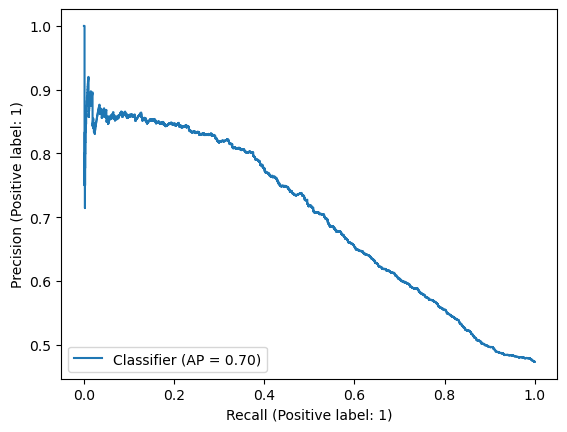

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

PrecisionRecallDisplay.from_predictions(y_true=list(pred_df['LABELS']), y_pred=list(pred_df['Sensitivity']))

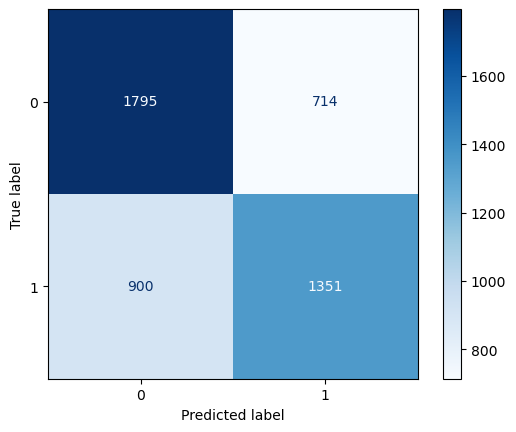

In [46]:
cm = confusion_matrix(y_true=list(pred_df['LABELS']), y_pred=list(pred_df['LABELS_PRED']))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


## SVM and GBDT

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from model.data import Dataset
from model.nn import CalculateSimilarity

In [4]:
ds = Dataset()

Loading Copy Number Abberation Data...
Loading Copy Number Abberation Data Done
Loading Gene Expression Data...
Loading Gene Expression Data Done
Begin loading drug data...
After filtering, GDSC has tested 477 drugs; CTRP has tested 425 drugs
After combining, unique cid number is 792


/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_cdf
  np.place(out, cond, f(*temp))
/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6630: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


Drug data loaded
Loading GDSC Experiment Data...
Loading Experiment Data Done
Begin Preprocessing Experiment!
Select Overlapping Cellines...
Index(['DATASET', 'CELL_LINE_NAME', 'DRUG_NAME', 'LN_IC50', 'AUC'], dtype='object')
Select Overlapping Cellines with available PubChem CIDs...
Create Unique Sample Barcode...
Exclude response value...
Experiment Done!
Preparing Omics data...
Omics data Done!


In [13]:
cal = CalculateSimilarity(sample_matrix=ds.omics_data['cnv'])

In [17]:
ds.omics_data['cnv']

celline_barcode,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
KYSE-410,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0
HT-144,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-2.0,-1.0,-1.0
BICR10,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
CAKI-1,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,-1.0
NCI-H1436,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LK-2,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0
L-1236,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,...,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0
HCC2157,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
U031,-1.0,-1.0,-1.0,1.0,1.0,1.0,-2.0,1.0,1.0,1.0,...,0.0,1.0,-1.0,1.0,1.0,0.0,0.0,2.0,-1.0,0.0


In [10]:
import keras.backend as K

t = K.zeros_like(ds.omics_data['cnv'][:3])

In [14]:
t.shape

TensorShape([3, 20669])

In [19]:
K.max(cal(t))

<tf.Tensor: shape=(), dtype=float32, numpy=0.60169774>

## SHAP

In [29]:
import pandas as pd
import shap
def make_shap(model, candidate, ds, batch_size):
    """

    Args:
        candidate (list): list["CELLINE_DRUG"]
        ds (Dataset): Dataset Object
    """
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    for i in ds.feature_contained:
        if i == "cnv":
            feature['cnv'] = ds.omics_data['cnv'].loc[celline_candidate].values.astype(np.float32)
        elif i == "gene_expression":
            feature['gene_expression'] = ds.omics_data['gene_expression'].loc[celline_candidate].values.astype(np.float32)
        elif i == "mutation":
            feature['mutation'] = ds.omics_data['mutation'].loc[celline_candidate].values.astype(np.float32)
        elif i == "methylation":
            feature['methylation'] = ds.omics_data['methylation'].loc[celline_candidate].values.astype(np.float32)
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)

    explainer = shap.Explainer(model)
    return explainer(feature)

In [53]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect 
from rdkit.Chem.Fingerprints import FingerprintMols
onbits = {}
from rdkit.Chem import MACCSkeys

a = Chem.MolFromSmiles('CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1')
Mkeys = MACCSkeys.GenMACCSKeys(a)
Morgan = GetMorganFingerprintAsBitVect(a, 2, nBits=1024)

In [54]:
np.array(Morgan).__len__()

512

In [125]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(descriptor_names)

In [127]:
def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [129]:
smi_to_descriptors('CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1').__len__()

43

In [99]:
np.array(AP).__len__()

2048

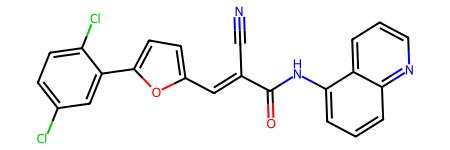

In [78]:
a

In [101]:
np.array(TT)

array([0, 0, 0, ..., 1, 0, 0])

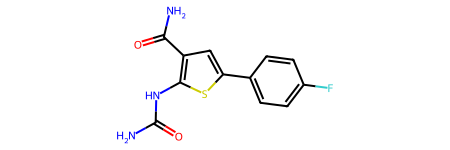

In [64]:
a = Chem.MolFromSmiles('NC(=O)Nc1sc(cc1C(N)=O)-c1ccc(F)cc1')
a